# Imports & Setup

In [35]:
import os, sys
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import unicodedata
import nltk
nltk.download('wordnet')
from nltk import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\heath\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#set parent directory
current_directory = os.getcwd()

In [4]:
df = pd.read_csv("translatedlyrics.csv")

# Stop Words

In [59]:
def fetch_and_save_stopwords(url, path="stopwords.txt"):
    # Fetch raw stopwords text
    raw = requests.get(url).content.decode()

    # Split by commas, strip whitespace, lowercase, and dedupe
    tokens = {t.strip().lower() for t in raw.split(",") if t.strip()}

    # Save back as one word per line
    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(sorted(tokens)))

    print(f"Stopwords saved to {path} ({len(tokens)} words)")

In [60]:
url = "https://gist.githubusercontent.com/ZohebAbai/513218c3468130eacff6481f424e4e64/raw/b70776f341a148293ff277afa0d0302c8c38f7e2/gist_stopwords.txt"
fetch_and_save_stopwords(url)

Stopwords saved to stopwords.txt (1158 words)


In [75]:
extra_words = ["chorus", "verse", "ive","ill","dont","doesnt"]

# Custom Functions

In [83]:
def basic_clean(string):
    if not isinstance(string, str):
        return ""
    
    # Normalize Unicode
    string = (
        unicodedata.normalize('NFKD', string)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
    )
    
    # Replace ALL newline-like sequences with spaces
    string = string.replace("\\n", " ") 
    string = re.sub(r"\s*\n\s*", " ", string)   # handles multiple \n
    
    # Remove punctuation
    string = re.sub(r"[^\w\s]", "", string)
    
    # Lowercase
    string = string.lower()
    
    # Collapse multiple spaces
    string = re.sub(r"\s+", " ", string).strip()
    
    return string


def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)


def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    return " ".join(stems)


def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    return " ".join(lemmas)


def load_stopwords(extra_words=None, exclude_words=None):
    extra_words = extra_words or []
    exclude_words = exclude_words or []
    
    # Load stopwords from local file
    with open("stopwords.txt", "r", encoding="utf-8") as f:
        stopword_set = set(f.read().splitlines())
    
    # Adjust with exclude/extra words
    stopword_set = stopword_set - set(exclude_words)
    stopword_set = stopword_set.union(set(extra_words))
    
    return stopword_set


def remove_stopwords(string, extra_words=None, exclude_words=None, min_len=3):
    stopword_set = load_stopwords(extra_words, exclude_words)
    words = string.split()
    filtered_words = [w for w in words if w not in stopword_set and len(w) >= min_len and w.isalpha()
                     ]
    return " ".join(filtered_words)


def clean(text, extra_words=extra_words, exclude_words=None):
    return remove_stopwords(lemmatize(basic_clean(text)), extra_words, exclude_words)

# Apply

In [84]:
df["processed_lyrics"] = df["lyrics_en"].apply(clean)
print(df.head())

   year to_country_id   to_country                  artist  \
0  1956            ch  Switzerland               Lys Assia   
1  1956            nl  Netherlands             Jetty Paerl   
2  1956            be      Belgium             Fud Leclerc   
3  1956            de      Germany  Walter Andreas Schwarz   
4  1956            fr       France            Mathé Altéry   

                              song  place_contest  sf_num  running_final  \
0                          Refrain            2.0     NaN            2.0   
1            De Vogels Van Holland            2.0     NaN            1.0   
2  Messieurs Les Noyés De La Seine            2.0     NaN            3.0   
3    Im Wartesaal Zum Großen Glück            2.0     NaN            4.0   
4                   Le Temps Perdu            2.0     NaN            5.0   

   running_sf  place_final  ...                              youtube_url  \
0         NaN          2.0  ...  https://youtube.com/watch?v=IyqIPvOkiRk   
1         NaN     

## save new csv

In [87]:
df.to_csv("tokenisedlyrics.csv", index=False)

# Code Word Cloud

## save txt file 

In [85]:
#Create Continuous corpus for overall wordcloud
with open("cloudtext.txt", "w", encoding="utf-8") as f:
    f.write(" ".join(df["processed_lyrics"].astype(str)))

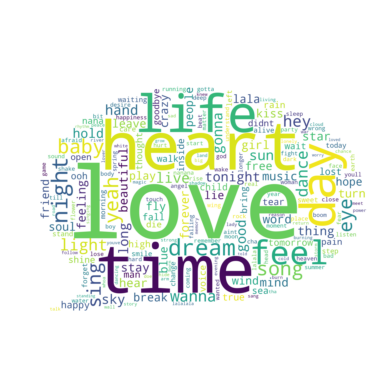

In [90]:
#set image as a variable
e_image_path = os.path.join(current_directory, "comment.png")
e_image = Image.open(e_image_path)

#pixel array 
e_mask = np.array(e_image)

#used print statement to debug and then commented out
#print(e_mask)

#read in text str from .txt file
with open(os.path.join(current_directory, "cloudtext.txt")) as f:
  lyrics = f.read()

#generate wordcloud
wordcloud = WordCloud(background_color="white", mask=e_mask, collocations=False, stopwords=STOPWORDS, contour_color="white", contour_width=1)

wordcloud.generate(lyrics)

#used print statement to debug and then commented out
#print(wordcloud)

image_colors = ImageColorGenerator(e_mask)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud.png", dpi=300, bbox_inches="tight")
plt.show()